In [38]:
from numpy import matrix, linspace, array, interp, pi
from control import ss, lqr, tf, step_response
from scipy.integrate import ode

In [39]:
%matplotlib inline
from matplotlib.pyplot import figure, style
from matplotlib import rc, rcParams

style.use("ggplot")
rcParams['text.latex.preamble']=[r"\usepackage{cmbright}"]

params = {'text.usetex' : True,
          'font.size' : 18}
rcParams.update(params) 

rc('font',**{'family':'sans-serif','sans-serif':['Noto Sans']})

In [40]:
def generacion_trayectorias_senoidal(t0, t1, n, A, ω):
    from numpy import sin, linspace
    from control import forced_response, tf
    
    f = lambda t: A*sin(ω*t)
    ts = linspace(t0, t1, n)
    us = [f(t) for t in ts]
    
    fso0 = tf([400], [1, 40, 400])
    fso1 = tf([400, 0], [1, 40, 400])
    fso2 = tf([400, 0, 0], [1, 40, 400])
    
    ts, nus, xs = forced_response(fso0, ts, us)
    ts, nu̇s, xs = forced_response(fso1, ts, us)
    ts, nüs, xs = forced_response(fso2, ts, us)
    
    return ts, nus, nu̇s, nüs

class motor_cd:
    def __init__(self, a, b, kp, kd, tipo_control, tiempos, trayectorias):
        from numpy import sin, cos, pi, interp
        self.a = a
        self.b = b
        self.kp = kp
        self.kd = kd
        self.ts = tiempos
        self.p_sat = 255
        self.qds, self.q̇ds, self.q̈ds = trayectorias
        
        if tipo_control is "nulo":
            self.control = self.control_nulo
            
        if tipo_control is "PD":
            self.control = self.control_PD
            
        if tipo_control is "PD_grav":
            self.control = self.control_PD_grav
            
        if tipo_control is "PD_mas":
            self.control = self.control_PD_mas
            self.λ = self.kp/self.kd
        
    def ec_movimiento(self, t, x):
        q, q̇ = x
        τ = self.control(t, x)
        return [q̇, self.b*τ - self.a*q̇]
    
    def inter_tray(self, t):
        from numpy import interp
        return interp(t, self.ts, self.qds), interp(t, self.ts, self.q̇ds), interp(t, self.ts, self.q̈ds)
    
    def control_nulo(self, t, x):
        return 0
    
    def control_PD(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        return self.kp*(qd - q) + self.kd*(0 - q̇)
    
    def control_PD_grav(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        return self.kp*(qd - q) + self.kd*(0 - q̇) + self.m*self.g*self.l*cos(q)
    
    def control_PD_mas(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        m = 1/self.b
        c = self.a/self.b
        g = 0
        e, ė = qd - q, q̇d - q̇
        u = m*q̈d + c*q̇d + g + (self.kd + m*self.λ)*ė + (self.kp + c*self.λ)*e
        return int(max(min(self.p_sat, u), -self.p_sat))

In [43]:
t0, tf, x0 = 0, 10, [0, 0]
n = 1000
δt = (tf - t0)/n

ts, tras, traps, trapps = generacion_trayectorias_senoidal(t0, tf, n, 100, 0.5*pi)

a, b = 11.25806587, 11.75121897
kp, kd = 10, 0.69144132

servo_HS422_PD_mas = motor_cd(a, b, kp, kd, "PD_mas", ts, [tras, traps, trapps])

sis = ode(servo_HS422_PD_mas.ec_movimiento)
sis.set_initial_value(x0, t0)
sis.set_integrator('vode', nsteps=300, method="bdf")

xs = [array(x0)]
ts1 = [t0]
for i in range(n):
    xs.append(sis.integrate(sis.t + δt))
    ts1.append(sis.t)
    
us = [servo_HS422_PD_mas.control(t, x) for t, x in zip(ts, xs)]

In [44]:
es = array([interp(t, ts, tras) for t in ts1]) - array(xs).T[0]

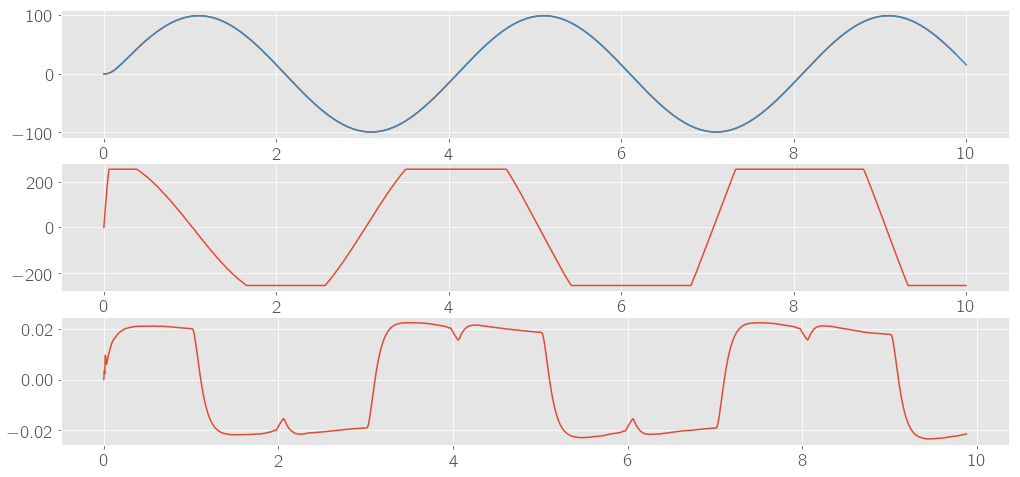

In [45]:
fig = figure(figsize=(17,8))
ax1, ax2, ax3 = fig.subplots(3,1)
ax1.plot(ts1, array(xs).T[0])
ax1.plot(ts, tras)
ax2.plot(ts, us)
ax3.plot(ts1, es);

In [ ]:
from serial import Serial
from time import time, sleep

In [ ]:
def alg_control(xs, t, kp, kd):
    p_sat = 255
    e = referencias(t) - xs[-1]
    ep = xs[-1] - xs[-2]
    u = kp*e - kd*ep
    return int(max(min(p_sat,u),-p_sat))

def referencias(t):
    from numpy import interp
    if t >= 5:
        return 127
    else:
        return 0

In [ ]:
xs = [0]
us = [0]
ts = [0]

with Serial("/dev/cu.usbserial-A603QGMH", baudrate=2000000) as puerto_arduino:
    while ts[-1] < 15:
        #puerto_arduino.reset_input_buffer()
        try:
            lec = int.from_bytes(puerto_arduino.read(6), byteorder='little')
            xs.append(int(lec/(2**32))/4)
            ts.append(int(lec%(2**32))*0.000001)
        except KeyboardInterrupt:
            break
        
        if len(xs) > 1:
            us.append(alg_control(xs[-2:], ts[-1], K[0][0], K[0][1]))
        else:
            us.append(0)
            
        if us[-1] > 0:
            puerto_arduino.write(bytes([0, us[-1]]))
        else:
            puerto_arduino.write(bytes([1, abs(us[-1])]))